# Waste Clssifier Image Classification Model


## 1. Loading Data

In [69]:
import os
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [71]:
import kagglehub
path = kagglehub.dataset_download("zlatan599/garbage-dataset-classification")

print("Path to dataset files:", path)

print("\nContents of dataset directory:")
for item in os.listdir(path):
    item_path = os.path.join(path, item)
    if os.path.isdir(item_path):
        print(f"📁 {item}/ - {len(os.listdir(item_path))} items")
    else:
        print(f"📄 {item}")

# Check one level deeper
print("\nLooking deeper:")
for item in os.listdir(path):
    item_path = os.path.join(path, item)
    if os.path.isdir(item_path):
        for subitem in os.listdir(item_path)[:5]:  # Show first 5 items
            print(f"  {item}/{subitem}")

Path to dataset files: C:\Users\Yousef Shahin\.cache\kagglehub\datasets\zlatan599\garbage-dataset-classification\versions\5

Contents of dataset directory:
📁 Garbage_Dataset_Classification/ - 2 items

Looking deeper:
  Garbage_Dataset_Classification/images
  Garbage_Dataset_Classification/metadata.csv


## 2. Visualizing the data

## 3. Creating the Model

This model uses Convolutional Nerual Networks to classify images

In [76]:
torch.manual_seed(42)
model_1 = WasteClassifierModelV1(input_shape=3, hidden_units=64, output_shape=len(full_dataset.classes)).to(device)
model_1

WasteClassifierModelV1(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [77]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    params=model_1.parameters(),
    lr=0.001
)

In [79]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):

    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [80]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        return test_loss, test_acc

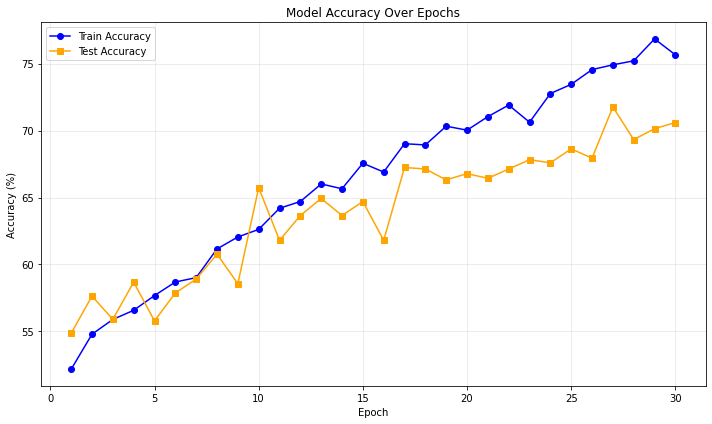

In [87]:
def plot_accuracy_curve(train_accuracies, test_accuracies, epochs):
    plt.figure(figsize=(10, 6))
    
    epoch_range = range(1, epochs + 1)
    
    plt.plot(epoch_range, train_accuracies, label='Train Accuracy', marker='o', color='blue')
    plt.plot(epoch_range, test_accuracies, label='Test Accuracy', marker='s', color='orange')
    
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Accuracy Over Epochs')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_accuracy_curve(train_accuracies, test_accuracies, epochs)

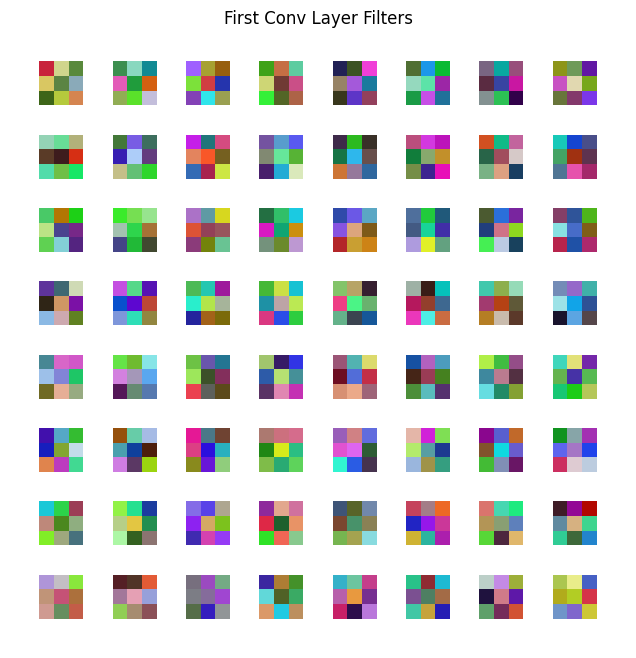

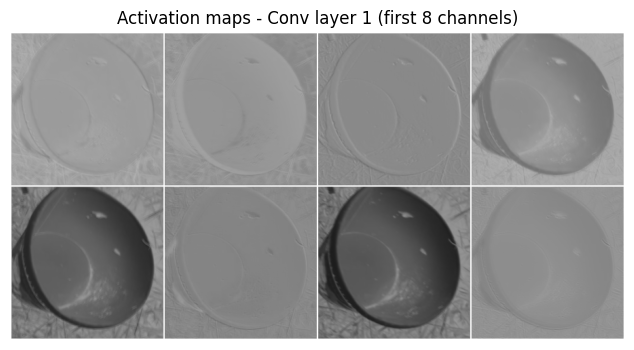

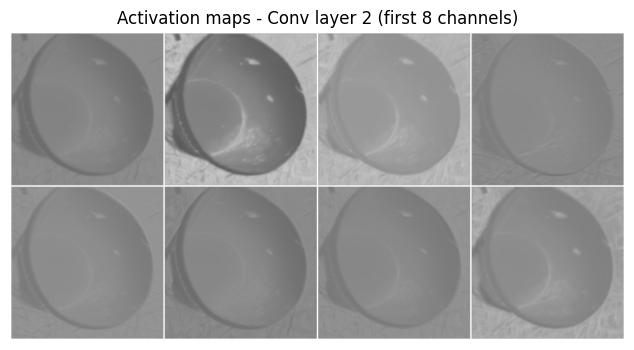

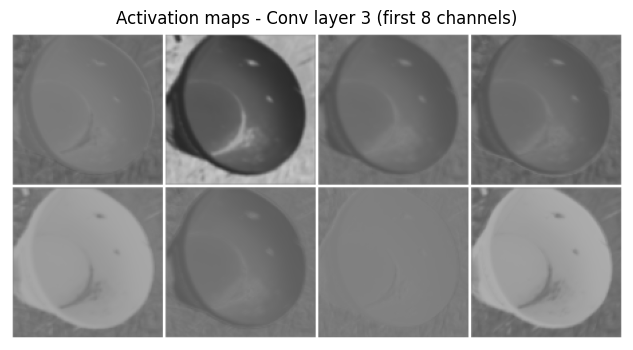

Sample ground-truth label: paper


In [31]:
# Visualize CNN filters (first conv layer) and activation maps for a sample image
from torchvision.utils import make_grid
import numpy as np
import torch.nn as nn

# Helper: find first few Conv2d layers in the model
def get_conv_layers(model, max_layers=3):
    convs = []
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            convs.append(m)
            if len(convs) >= max_layers:
                break
    return convs

# Visualize the learned filters of the first conv layer
conv_layers = get_conv_layers(model_1, max_layers=1)
if len(conv_layers) == 0:
    print('No Conv2d layers found in the model.')
else:
    conv0 = conv_layers[0]
    # conv0.weight shape: (out_chan, in_chan, kH, kW)
    w = conv0.weight.data.clone().cpu()
    # Normalize weights to 0..1 for visualization
    w_min, w_max = w.min(), w.max()
    w_norm = (w - w_min) / (w_max - w_min + 1e-8)
    # Make a grid (will show filters as RGB images when in_chan==3)
    grid = make_grid(w_norm, nrow=8, normalize=False, pad_value=1)
    plt.figure(figsize=(8, 8))
    plt.title('First Conv Layer Filters')
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Activation maps for a sample test image (first item in test set)
# Get a sample image from `test_data` (a Subset) and ensure it's an image tensor
try:
    sample_img, sample_label = test_data[0]
except Exception as e:
    # fallback to test_loader first batch
    print('Could not index test_data directly, using first batch from test_loader. Error:', e)
    batch = next(iter(test_loader))
    sample_img, sample_label = batch[0][0], batch[1][0]

# Prepare image and register hooks to capture activations
activations = []
hooks = []
def hook_fn(module, inp, out):
    activations.append(out.detach().cpu())

# Register hooks on the first 3 conv layers (or less if not present)
conv_layers = get_conv_layers(model_1, max_layers=3)
for conv in conv_layers:
    hooks.append(conv.register_forward_hook(hook_fn))

# Forward pass the sample image
model_1.to(device)
model_1.eval()
with torch.inference_mode():
    img_batch = sample_img.unsqueeze(0).to(device)
    _ = model_1(img_batch)

# Remove hooks
for h in hooks:
    h.remove()

# Plot activation maps from each hooked layer
for i, act in enumerate(activations):
    # act shape: (batch, channels, H, W)
    act = act[0]  # take the first (and only) batch item
    n_maps = min(8, act.shape[0])
    # normalize each map for display
    act_min, act_max = act.min(), act.max()
    act_norm = (act - act_min) / (act_max - act_min + 1e-8)
    maps = act_norm[:n_maps].unsqueeze(1)  # (n_maps,1,H,W)
    # make grid and plot
    grid = make_grid(maps, nrow=4, normalize=False, pad_value=1)
    plt.figure(figsize=(10, 4))
    plt.title(f'Activation maps - Conv layer {i+1} (first {n_maps} channels)')
    plt.imshow(grid.squeeze().numpy(), cmap='viridis') if grid.shape[0]==1 else plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
    plt.axis('off')
    plt.show()

print('Sample ground-truth label:', full_dataset.classes[sample_label])

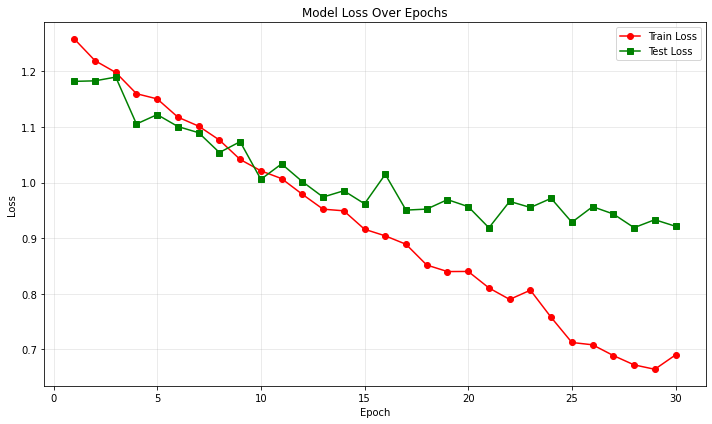

In [28]:
def plot_loss_curve(train_losses, test_losses, epochs):

    plt.figure(figsize=(10, 6))
    
    epoch_range = range(1, epochs + 1)
    
    # Convert tensors to CPU if needed
    train_losses_cpu = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in train_losses]
    test_losses_cpu = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in test_losses]
    
    plt.plot(epoch_range, train_losses_cpu, label='Train Loss', marker='o', color='red')
    plt.plot(epoch_range, test_losses_cpu, label='Test Loss', marker='s', color='green')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss Over Epochs')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Call the function with your stored losses
plot_loss_curve(train_losses, test_losses, epochs)